In [6]:
#!/usr/bin/python

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

In [7]:
# Some helpful functions

# Function to quick plot
def poi_scatter(labels, data, x=0, y=1, x_label=None, y_label=None, size=150):
    """
    Function to quickly plot a scatter with poi marked out
    Defaults to plotting the second column vs. first column
    """
    n_data = len(labels)
    x_poi = [data[ii][x] for ii in range(n_data) if labels[ii] == 1]
    y_poi = [data[ii][y] for ii in range(n_data) if labels[ii] == 1]
    x_npoi = [data[ii][x] for ii in range(n_data) if labels[ii] == 0]
    y_npoi = [data[ii][y] for ii in range(n_data) if labels[ii] == 0]
    plt.scatter(x_poi, y_poi, color="r", label="poi", s=size)
    plt.scatter(x_npoi, y_npoi, color="b", label="non_poi", s=size)
    plt.legend(scatterpoints=1)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)
    plt.show()

# Create a function to test our classifier
# More detailed stats
def clf_test(labels, pred):
    if len(labels) != len(pred):
        print "Lists not of same length"
        return
    tp = 0 # True positives
    tn = 0 # True negatives
    fp = 0 # False positives
    fn = 0 # False negatives
    for i in range(len(labels)):
        if labels[i] == pred[i]:
            if labels[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if labels[i] == 0:
                fp += 1
            else:
                fn += 1
    print "Accuracy: ", ((tp+tn) / float(len(labels)))
    print "Recall: ", float(tp) / (tp + fn)
    print "Precision: ", float(tp) / (tp + fp)

In [8]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi",
                 "salary",
                 "deferral_payments",
                 "loan_advances",
                 "bonus",
                 "restricted_stock_deferred",
                 "deferred_income",
                 "total_stock_value",
                 "expenses",
                 "exercised_stock_options",
                 "other",
                 "long_term_incentive",
                 "restricted_stock",
                 "director_fees",
                 "from_poi_to_this_person_ratio",
                 "from_this_person_to_poi_ratio"]

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

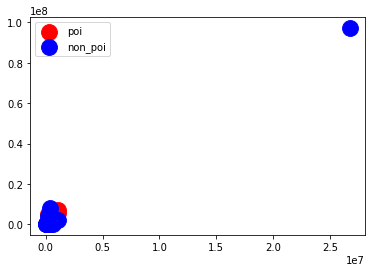

In [9]:
### Task 2: Remove outliers
# Salary and bonus plot
plot_data = featureFormat(data_dict, ["poi", "salary", "bonus"], sort_keys = True)
plot_labels, plot_features = targetFeatureSplit(plot_data)
poi_scatter(plot_labels, plot_features)

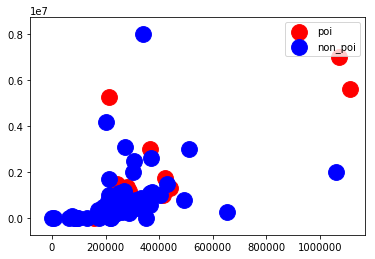

In [10]:
# From above we realise that the "TOTAL" column had been included
del data_dict["TOTAL"]

# Replot to be sure
plot_data = featureFormat(data_dict, ["poi", "salary", "bonus"], sort_keys = True)
plot_labels, plot_features = targetFeatureSplit(plot_data)
poi_scatter(plot_labels, plot_features)

In [11]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict

# Feature that expresses emails to/from poi as a ratio of total emails
# Where there is no feature we save "NaN" as per featureFormat
for person in my_dataset.keys():
    person_data = my_dataset[person]
    # Create ratio for received messages
    if person_data["to_messages"] != 0 and person_data["to_messages"] != "NaN":
        if person_data["from_poi_to_this_person"] != "NaN":
            person_data["from_poi_to_this_person_ratio"] = (
                person_data["from_poi_to_this_person"] / float(person_data["to_messages"]))
        else:
            person_data["from_poi_to_this_person_ratio"] = "NaN"
    else:
        person_data["from_poi_to_this_person_ratio"] = "NaN"
    # Create ratio for from messages
    if person_data["from_messages"] != 0 and person_data["from_messages"] != "NaN":
        if person_data["from_this_person_to_poi"] != "NaN":
            person_data["from_this_person_to_poi_ratio"] = (
                person_data["from_this_person_to_poi"] / float(person_data["from_messages"]))
        else:
            person_data["from_this_person_to_poi_ratio"] = "NaN"
    else:
        person_data["from_this_person_to_poi_ratio"] = "NaN"

In [40]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

# Print some stats about our data
print "Total Number of People: %d" % (len(data_dict.keys()))
print "Sample: %d" % len(labels)
print "Number of POIs: %d" % sum(labels)

# Find who is missing?

Total Number of People: 145
Sample: 144
Number of POIs: 18


In [20]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Select K Best
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif)
k_range = range(len(features_list))[1:] # Test all combinations

# MinMax Scaler - useful for variance dependent classifiers (e.g. SVMs)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [23]:
# Select classifer here - loop through classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn import neighbors

clf_list = ["gaussian",
            "decision_tree",
            "svm",
            "k_neighbours"]

def set_clf_params(clf_name):
    if clf_name == "gaussian":
        clf = GaussianNB()
        params = {
            "select__k": k_range,
        }
    elif clf_name == "decision_tree":
        clf = tree.DecisionTreeClassifier()
        params = {
            "select__k": k_range,
            "clf__criterion": ["entropy", "gini"],
            "clf__min_samples_split": [2, 10, 20, 30, 40, 50]
        }
    elif clf_name == "svm":
        clf = SVC()
        params = {
            "select__k": k_range,
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [1, 3, 5, 10, 20]
        }
    elif clf_name == "k_neighbours":
        clf = neighbors.KNeighborsClassifier()
        params = {
            "select__k": k_range,
            "clf__weights": ["distance", "uniform"],
            "clf__n_neighbors": [3, 5, 7, 9] # With only 18 pois, can't be too high
        }
    else:
        print "No valid selection"
        return None
    return clf, params


In [24]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
# Loop through clf
for clf_name in clf_list:
    clf, params = set_clf_params(clf_name)

    # Pipeline estimators - each should be ("name", estimator) format
    
    estimators = [("select", selector),
                  ("scaler", scaler),
                  ("clf", clf)]
    pipe = Pipeline(estimators)
    #pipe.get_params().keys()
    
    ### Task 5: Tune your classifier to achieve better than .3 precision and recall 
    ### using our testing script. Check the tester.py script in the final project
    ### folder for details on the evaluation method, especially the test_classifier
    ### function. Because of the small size of the dataset, the script uses
    ### stratified shuffle split cross validation. For more info: 
    ### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

    # Example starting point. Try investigating other evaluation techniques!
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)

    # GridSearchCV
    gridsearch = GridSearchCV(pipe, param_grid=params)

    gridsearch.fit(features_train, labels_train)
    
    print "Best results for %s" % clf_name
    print gridsearch.best_estimator_
    print "*****"

# View results below

Best results for gaussian
Pipeline(steps=[('select', SelectKBest(k=1, score_func=<function f_classif at 0x11751e050>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', GaussianNB(priors=None))])
*****
Best results for decision_tree
Pipeline(steps=[('select', SelectKBest(k=3, score_func=<function f_classif at 0x11751e050>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
*****
Best results for svm
Pipeline(steps=[('select', SelectKBest(k=1, score_func=<function f_classif at 0x11751e050>)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=

The results above are slightly surprising for 3 of the algorithms, the optimal k=1 for SelectKBest. This would suggest overfitting for a single parameter. Nevertheless, without making any judgement we will test all the found optimal results. 

The results for decision_tree seem promising though as it selects 3 variables.

In [31]:
def set_optimal_clf(clf_name):
    if clf_name == "gaussian":
        selector = SelectKBest(f_classif, k=1)
        clf = GaussianNB()
    elif clf_name == "decision_tree":
        selector = SelectKBest(f_classif, k=3)
        clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=30)
    elif clf_name == "svm":
        selector = SelectKBest(f_classif, k=1)
        clf = SVC(kernel="rbf", C=3)
    elif clf_name == "k_neighbours":
        selector = SelectKBest(f_classif, k=1)
        clf = neighbors.KNeighborsClassifier(weights="uniform", n_neighbors=7)
    else:
        print "No valid selection"
        return None
    return selector, clf

for clf_name in clf_list:
    # Set optimal selector, clf
    selector, clf = set_optimal_clf(clf_name)
    
    estimators = [("select", selector),
                  ("scaler", scaler),
                  ("clf", clf)]
    pipe = Pipeline(estimators)
    
    # Setup train-test split
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    
    # Print test results
    if clf_name == "decision_tree":
        pipe.fit_transform(features_train, labels_train)
    else:
        pipe.fit(features_train, labels_train)
    pred = pipe.predict(features_test)
    
    print "Results for %s" % clf_name
    print "Test size: %d Number of test POIs: %d" % (len(labels_test), sum(labels_test))
    clf_test(labels_test, pred)
    print "*****"
    

Results for gaussian
Test size: 44 Number of test POIs: 5
Accuracy:  0.840909090909
Recall:  0.2
Precision:  0.25
*****
Results for decision_tree
Test size: 44 Number of test POIs: 5
Accuracy:  0.840909090909
Recall:  0.6
Precision:  0.375
*****
Results for svm
Test size: 44 Number of test POIs: 5
Accuracy:  0.863636363636
Recall:  0.0
Precision:  0.0
*****
Results for k_neighbours
Test size: 44 Number of test POIs: 5
Accuracy:  0.886363636364
Recall:  0.2
Precision:  0.5
*****


/anaconda/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


We see that our test set is only 44 persons, with 5 POIs. Therefore returning 44 zeroes would give an accuracy of 88.6% (that is pretty much what our svm has done). Ideally we would like our algorithm to have a high recall, even at the expense of lower precision. This is because given how few POIs there are we would like to ensure that we select most of them even expense of a few more false negatives - this is because being identified by the algorithm as a POI would likely not have immediate legal consequences, but rather flag the person for further investigation (with may then show he is not a POI).

In [38]:
# Final estimator checking
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
selector = SelectKBest(f_classif, k=3)
scaler = MinMaxScaler()
clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=30)

fitted = selector.fit(features_train, labels_train)
rank = np.argsort(fitted.scores_)[::-1]
print "Features by importance from KSelectBest"
for ii in rank:
    print zip(features_list[1:], fitted.scores_)[ii]


Features by importance from KSelectBest
('bonus', 30.652282305660439)
('salary', 15.806090087437418)
('from_this_person_to_poi_ratio', 13.791413236761116)
('total_stock_value', 10.814634863040405)
('exercised_stock_options', 9.9561675820785211)
('deferred_income', 8.4934970305461821)
('restricted_stock', 8.0511018969982544)
('long_term_incentive', 7.5345222400328424)
('loan_advances', 7.0379327981934612)
('expenses', 4.3143955730810664)
('other', 3.1966845043285219)
('director_fees', 1.6410979261701475)
('restricted_stock_deferred', 0.67928033895169282)
('from_poi_to_this_person_ratio', 0.49060990360486301)
('deferral_payments', 0.0098194464190455126)


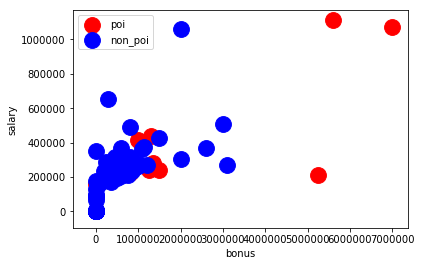

In [35]:
# View top 2 visually:
poi_scatter(labels_train, features_train, x=rank[0], y=rank[1], \
           x_label=features_list[1:][rank[0]], y_label=features_list[1:][rank[1]])

In [39]:
trans_features_train = selector.transform(features_train)
trans_features_test = selector.transform(features_test)
clf.fit(trans_features_train, labels_train)
pred = clf.predict(trans_features_test)
clf_test(labels_test, pred)

Accuracy:  0.840909090909
Recall:  0.6
Precision:  0.375


In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

#dump_classifier_and_data(clf, my_dataset, features_list)